The objective of this assignment is to become familiar with the functionality of multilayer perceptron (MLP) neural networks, including their training, evaluation, and the application of regularization, optimization, and related techniques. <br>
The dataset used in this work is the MNIST dataset of handwritten English digits, consisting of 70,000 samples—60,000 for training and 10,000 for testing in its standard form.

# Modules

In [1]:
import copy

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score, precision_score, recall_score
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import torchvision.datasets as datasets
import torchvision.transforms as transforms

# Q1

Split the data into training, validation, and test sets. For validation, you should set aside 10% of the training dataset initially. Then, normalize the data.

## Load Data and Normalization

### train and validation set

In [33]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

In [34]:
# Load train data
train_dataset = datasets.MNIST(root='dataset/', train=True, transform=transform, download=True)

# 90% for training, 10% for validation
train_size = int(0.9 * len(train_dataset))
valid_size = len(train_dataset) - train_size

# Split the dataset
train_set, val_set = random_split(train_dataset, [train_size, valid_size])

print(f"""number of data samples in training set: {len(train_set)},
number of data samples in validation set: {len(val_set)},""")

number of data samples in training set: 54000,
number of data samples in validation set: 6000,


### test set

In [35]:
# Load test data
test_dataset = datasets.MNIST(root='dataset/', train=False, transform=transform, download=True)

print(f"number of data samples in test set: {len(test_dataset)}")

number of data samples in test set: 10000


In [36]:
# Create DataLoaders 
train_loader = DataLoader(dataset=train_set, batch_size=64, shuffle=True)
valid_loader = DataLoader(dataset=val_set, batch_size=64, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

### Normalized and unnormalized data

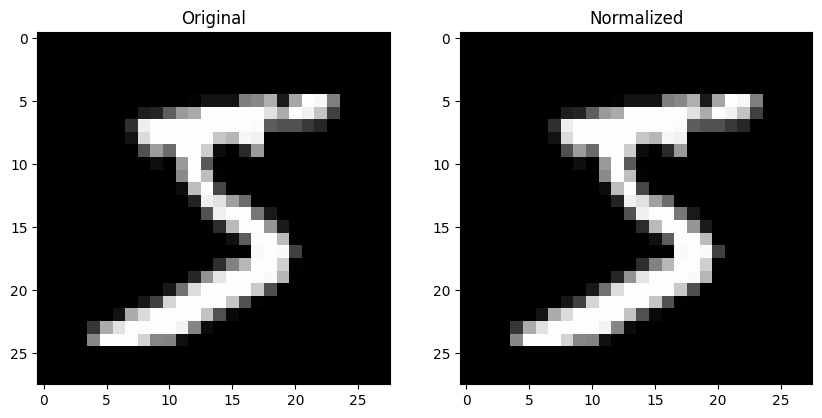

In [40]:
def denormalize(tensor, mean=0.1307, std=0.3081):
    return tensor * std + mean


# Compare images after and before normalization
idx = 0
normalized_img, label = train_dataset[idx]
unnormalized_img = denormalize(normalized_img)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(unnormalized_img.squeeze(), cmap='gray')
axes[0].set_title(f'Original')
axes[1].imshow(normalized_img.squeeze(), cmap='gray')
axes[1].set_title(f'Normalized')
plt.show()